In [ ]:
!pip install scikit-garden
!pip install setuptools numpy scipy scikit-learn cython

In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from skgarden import RandomForestQuantileRegressor

import warnings
warnings.filterwarnings("ignore")

C:\Users\Wayne Linn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Wayne Linn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. Import the train datasets

In [2]:
X_train = pd.read_csv("A_Normalised_train_data.csv",index_col=0)
Y_train = pd.read_csv("A_Log_sales_train.csv",index_col=0)

In [ ]:
Model_1 = RandomForestQuantileRegressor(n_estimators=100)

# 2. Setup Pipeline

In [ ]:
pca=PCA()
RG = Model_1

In [ ]:
# Step 1: PCA
# Step 2: Model
pipe = Pipeline(steps=[("pca",pca),("RG",RG)])

In [ ]:
param_grid = {
    #"pca__n_components": [50, 100,170]
}

# 3. Setup GridSearch

In [ ]:
score_metric = 'neg_mean_squared_error'
search = GridSearchCV(pipe,param_grid,
                      n_jobs=-1,
                      cv=10,
                      scoring=score_metric)

In [ ]:
search.fit(X_train,Y_train.values.ravel())

In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
df = pd.DataFrame(search.cv_results_)
df = df.sort_values(by=['rank_test_score'])
df

# 4. Best Hyperparameter

In [ ]:
parms = pd.DataFrame(df['params'])
for i in parms.iloc[0]:
    print(i)

# 5. Evaluate Model $log(Sales)$

In [50]:
#best_pca =parms.iloc[0][0]['pca__n_components']
#best_n_est = parms.iloc[0][0]['RG__n_estimators']
#best_min_ss=parms.iloc[0][0]['RG__min_samples_split']
best_pca=170
#best_lr=0.1
best_n_est=1000

In [51]:
Model_2 = RandomForestQuantileRegressor(n_estimators=best_n_est)

In [52]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X_train,Y_train,test_size=0.2,random_state=132)


In [53]:
pca1 = PCA(n_components=best_pca)
pca1.fit(X_train1)
PX_train1 = pca1.transform(X_train1)
RG1 = Model_2
RG1.fit(PX_train1,Y_train1.values.ravel())

RandomForestQuantileRegressor(n_estimators=1000)

In [54]:
pca2 = PCA(n_components=best_pca)
pca2.fit(X_test1)
PX_test1 = pca2.transform(X_test1)

In [55]:
MSE(RG1.predict(PX_test1),Y_test1)

1.4991414419290214

In [56]:
result = pd.DataFrame(np.exp(Y_test1))

In [57]:
result["Predicted_sales"] = np.exp(RG1.predict(PX_test1))

In [58]:
MSE(result["sales"],result["Predicted_sales"])

940.0862277658656

# 5.1 Model using original sales data

In [14]:
Model_3 = Model_2 = RandomForestQuantileRegressor(n_estimators=best_n_est)

In [15]:
OY_train = pd.read_csv("A_sales_train.csv",index_col=0)

In [16]:
X_train2,X_test2,Y_train2,Y_test2 = train_test_split(X_train,OY_train,test_size=0.2,random_state=132)

In [17]:
pca3 = PCA(n_components=best_pca)
pca3.fit(X_train2)
PX_train2 = pca3.transform(X_train2)
RG2 = Model_3
RG2.fit(PX_train2,Y_train2.values.ravel())

RandomForestQuantileRegressor(n_estimators=100)

In [18]:
pca4 = PCA(n_components=best_pca)
pca4.fit(X_test2)
PX_test2 = pca4.transform(X_test2)

In [19]:
MSE(RG2.predict(PX_test2),Y_test2)

2761.5083539956804

#### Notably model trained on log(Sales) has lower out-of-sample MSE than model with unmodified Sales

# 6. Inventory Decision

In [59]:
residual = result['sales']-result['Predicted_sales']

In [60]:
Price=20
Cost=12
Salvage=8
Over=Cost - Salvage
Under=Price - Cost
Over, Under

(4, 8)

### QQ plot to explore the distribution of residual

#### Normal Distribution

In [61]:
import scipy.stats as sct

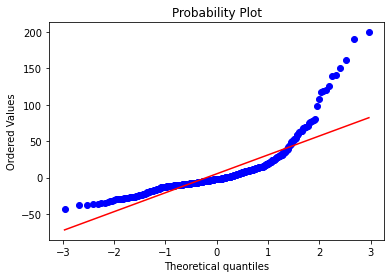

In [62]:
import scipy
scipy.stats.probplot(residual, dist="norm", plot=plt)
plt.show()

In [63]:
s = residual.std()
opt_dec_N=np.ceil(sct.norm.ppf(Under/(Under+Over))*s + result['Predicted_sales'])

#### Exponential Distribution

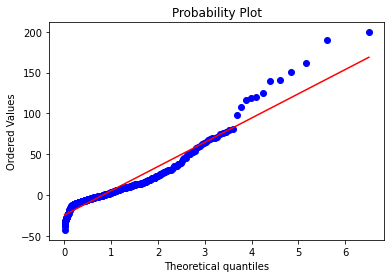

In [64]:
scipy.stats.probplot(residual, dist="expon", plot=plt)
plt.show()

In [65]:
opt_dec_E=np.ceil((-result['Predicted_sales'])*np.log(1-(Under/(Under+Over))))

#### Empirical Distribution

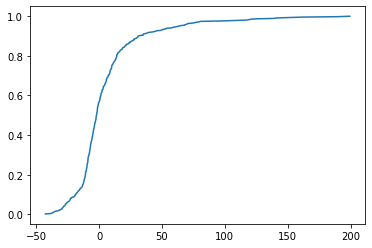

In [66]:
size = residual.shape[0]
step=1/size
jumps = [step*i for i in range(1,size+1)]
Sample = sorted(residual)
plt.plot(Sample,jumps)

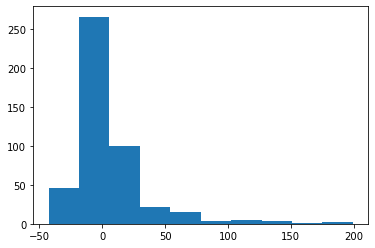

In [67]:
plt.hist(Sample)
plt.show()

In [68]:
def inv(sample,jump,area):
    size = len(sample)
    temp=0
    i=0
    while temp<area:
        temp=jump[i]
        i+=1
    return sample[i]

In [69]:
offset = inv(Sample,jumps,2/3)
offset

5.545908520371762

In [70]:
opt_dec_B = np.ceil(result['Predicted_sales']+offset)

# 7. Out-of-samples Profit

In [71]:
#max profit for test data set
max_profit = result['sales'].sum()*(Price-Cost)
max_profit

82096.0

In [72]:
def profit(demand,inv):
    return (Price-Salvage)*np.minimum(demand,inv)-(Cost-Salvage)*inv

In [73]:
#Profit (Normal)
profit_lst_N = profit(result['sales'],opt_dec_N)
profit_lst_N.sum()

27104.0

In [74]:
#Profit (Exponential)
profit_lst_E = profit(result['sales'],opt_dec_E)
profit_lst_E.sum()

29156.0

In [75]:
#Profit (Empirical)
profit_lst_B = profit(result['sales'],opt_dec_B)
profit_lst_B.sum()

29940.0

# 8. K-Fold Cross Validation

### Repeat steps 5,6,7 with 10-fold cross validation

In [37]:
Model_4= Model_2 = RandomForestQuantileRegressor(n_estimators=best_n_est,min_samples_split=best_min_ss)

In [38]:
from sklearn.model_selection import KFold
k=10
kf = KFold(n_splits=k)
X_train_t=X_train.to_numpy()
Y_train_t=Y_train.to_numpy()
model = []
mse_lst = []
max_profit_lst = []
profit_N_lst = []
profit_E_lst = []
profit_B_lst = []

for train_index,test_index in kf.split(X_train_t):
    X_train_K,X_test_K=X_train_t[train_index],X_train_t[test_index]
    Y_train_K,Y_test_K=Y_train_t[train_index],Y_train_t[test_index]
    
    #PCA to transform train data
    pca_K1 = PCA(n_components=best_pca)
    pca_K1.fit(X_train_K)
    PX_train_K = pca_K1.transform(X_train_K)
    
    #Model
    RG_K = Model_4
    RG_K.fit(PX_train_K,Y_train_K.ravel())
    
    #pca to transform test data
    pca_K2 = PCA(n_components=best_pca)
    pca_K2.fit(X_test_K)
    PX_test_K = pca_K2.transform(X_test_K)
    
    #MSE
    mse_lst.append(MSE(RG_K.predict(PX_test_K),Y_test_K))
    
    #Transform log(sale) back to sale
    result_K = pd.DataFrame(np.exp(Y_test_K))
    result_K["Predicted_sales"] = np.exp(RG_K.predict(PX_test_K))
    
    #Obtain residual
    residual_K = result_K[0]-result_K['Predicted_sales']
    
    #Get std for Normal distribution
    s_K = residual.std()
    
    #Inventory Decision (Normal)
    opt_dec_N_K=np.ceil(sct.norm.ppf(Under/(Under+Over))*s_K + result_K['Predicted_sales'])
    #Inventory Decision (Exponential)
    opt_dec_E_K=np.ceil((-result_K['Predicted_sales'])*np.log(1-(Under/(Under+Over))))
    
    #Inventory Decision (Empirical Distribution)
    size_K = residual_K.shape[0]
    step_K=1/size_K
    jumps_K = [step_K*i for i in range(1,size+1)]
    Sample_K = sorted(residual_K)
    offset_K = inv(Sample_K,jumps_K,2/3)
    opt_dec_B_K = np.ceil(result_K['Predicted_sales']+offset_K)
    
    #Out-of_sample profit
    profit_lst_B_K = profit(result_K[0],opt_dec_B_K)
    profit_B_lst.append(profit_lst_B_K.sum())
    
    profit_lst_N_K = profit(result_K[0],opt_dec_N_K)
    profit_N_lst.append(profit_lst_N_K.sum())
    
    profit_lst_E_K = profit(result_K[0],opt_dec_E_K)
    profit_E_lst.append(profit_lst_E_K.sum())
    
    max_profit_K = result_K[0].sum()*(Price-Cost)
    max_profit_lst.append(max_profit_K)
    
max_profit_lst = np.array(max_profit_lst)
profit_N_lst = np.array(profit_N_lst)
profit_E_lst = np.array(profit_E_lst)
profit_B_lst = np.array(profit_B_lst)

fraction_of_max_N = profit_N_lst/max_profit_lst
fraction_of_max_E = profit_E_lst/max_profit_lst
fraction_of_max_B = profit_B_lst/max_profit_lst

dist_profit = ["Normal","Exponential","Empirical","Max"]
dist_frac = ["Normal","Exponential","Empirical"]
col_name = ["Dataset_"+str(i) for i in range(1,k+1)]

profit_lst = [profit_N_lst,profit_E_lst,profit_B_lst,max_profit_lst]
profit_table = pd.DataFrame(profit_lst,index=dist_profit,columns=col_name)
profit_table["mean_profit"]=profit_table.mean(axis=1)
profit_table["std_profit"]=profit_table.std(ddof=1,axis=1)

fraction_lst = [fraction_of_max_N,fraction_of_max_E,fraction_of_max_B]
fraction_table = pd.DataFrame(fraction_lst,index=dist_frac,columns=col_name)
fraction_table["mean_fraction"]=fraction_table.mean(axis=1)

In [39]:
fraction_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5,Dataset_6,Dataset_7,Dataset_8,Dataset_9,Dataset_10,mean_fraction
Normal,0.303789,0.379265,0.317349,0.272704,0.260032,0.367855,0.202500,0.354467,0.339030,0.301863,0.309885
Exponential,0.330273,0.362383,0.286504,0.292446,0.270508,0.381377,0.222921,0.327754,0.345472,0.338936,0.315857
Empirical,0.338972,0.389429,0.324866,0.297682,0.283562,0.395001,0.235991,0.360451,0.362473,0.344602,0.333303


In [40]:
profit_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5,Dataset_6,Dataset_7,Dataset_8,Dataset_9,Dataset_10,mean_profit,std_profit
Normal,12572.0,17164.0,14692.0,12708.0,12908.0,14364.0,9916.0,16348.0,15156.0,12572.0,13840.0,2020.763420
Exponential,13668.0,16400.0,13264.0,13628.0,13428.0,14892.0,10916.0,15116.0,15444.0,14116.0,14087.2,1430.112499
Empirical,14028.0,17624.0,15040.0,13872.0,14076.0,15424.0,11556.0,16624.0,16204.0,14352.0,14880.0,1623.629514
Max,41384.0,45256.0,46296.0,46600.0,49640.0,39048.0,48968.0,46120.0,44704.0,41648.0,44966.4,3203.875254


In [41]:
profit_table.to_csv(".\\Model_Selection_Result\\5.1_Quantile_regression_forest.csv")